# Introducción

En el Notebook anterior llegamos a varias conclusiones e hicimos varios cambios en el Dataframe, estos cambios vamos a replicarlos aquí, pero aprovechando las conclusiones a las que llegamos:

* En un principio observamos una tabla con 8 columnas:

InvoiceNo = El número de la factura

StockCode = El codigo del producto

Description = La descripción del producto

Quantity = La cantidad de este producto en el pedido

InvoiceDate = La fecha y hora del pedido

UnitPrice = El precio por unidad

CustomerID = El codigo de cliente

Country = El país de compra

* Había datos faltantes y descripciones no incluidas. En el Notebook anterior las borramos, pero en este caso vamos a profundizar más en estos datos.

* Vimos que habia productos con precios inferiores a 0.01, los eliminamos

* Vimos que existian varios tipos de ordenes, algunos eran pedidos, otros gastos de envio, otros cargos al banco, exactamente eran ('POST' 'D' 'C2' 'M' 'BANK CHARGES' 'DOT' 'CRUK')

* Nos hicimos varias preguntas semillas:

* ¿Quienes cancelan mas pedidos?
* ¿Existen errores en las cancelaciones? (Que no sean de clientes por ejemplo)
* ¿De que paises vienen unos gastos de envios u otros?, ¿afecta el volumen?
* ¿Los cargos manuales vienen siempre de los mismos clientes?
* ¿En que pedidos hay Bank Charges? ¿Tiene que ver el metodo de pago? ¿Es siempre la misma comision?
* ¿Los CRUK son siempre devoluciones?¿Hay patrones entre aquellos clientes que usan CRUK?
* Habria que señalar de alguna manera aquellos pedidos que hayan sido cancelados, por un lado, no tenerlos en cuenta como compras, por otro lado ver patrones entre clientes o productos asociados a cancelaciones.

* Creamos varias columnas, estas eran

* tipo: El tipo de transaccion: puede ser ORDER, BANK, CRUK, etc
* Status: Si la transaccion es COMPLETED o CANCEL
* TotalSales: Cantidad total de ventas en Unidades monetarias que ha vendido ese producto
* TotalCancel: Cantidad total de cancelaciones en unidades monetarias que ha tenido ese producto
* TasaCancel: Proporcion de cancelaciones sobre el numero total de ordenes (Este dato hay que modificarlo, ya que tenia en cuenta que las ordenes y las cancelaciones eran independientes, es decir, que cada cancelacion era una orden cancelada, pero no existia su orden equivalente)
* CancelledCount: Cantidad de cancelaciones realizadas por ese cliente
* CompletedCount: Cantidad de ordenes realizadas por ese cliente
* TasaCancelCliente: Proporcion de cancelaciones sobre las totales realizadas por el cliente (Este dato tambien hay que modificarlo para que tenga en cuenta las orders Completed como ordenes totales)
* Precio Total: El el coste total de ese articulo en el pedido (Precio * Cantidad)
* Compras Totales: Total en unidades monetarias de compras realizadas por el cliente 
* Cancelaciones Totales: Total en unidades monetarias de cancelaciones realizadas por el cliente
* NetIncome: Ingreso Neto (TotalSales - TotalCancel)-> Este dato si está bien calculado teniendo en cuenta que contamos con que las ordenes canceladas tienen una contraparte como orden completada

* Nos dimos cuenta de que existian compras realizadas que eran un error, como por ejemplo PAPER CRAFT , LITTLE BIRDIE, que tiene un pedido de 80995, esto es una compra erronea y deberiamos evitar tener este tipo de pedidos en nuestro dataset ya que nubla el objetivo.

Bien, comencemos con el nuevo EDA teniendo en cuenta las conclusiones anteriores


# Importamos las librerias necesarias

In [66]:
import warnings
warnings.filterwarnings('ignore')

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Importamos el DataSet

In [68]:
df = pd.read_csv('data.csv',encoding='latin1')

# Revisamos el Dataframe

In [69]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


En este caso, antes de eliminar los valores nulos, vamos a comprobar si alguno son cancelaciones e intentaremos casarlas con ordenes completadas.
Las conclusiones realizadas en el anterior Notebook no se repetirán aquí para evitar redundancia, de esta manera los pasos ya realizados no se explicarán para mejorar la fluidez.

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [71]:
# Comprobar valores nulos
df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [72]:
# veamos cuantas veces se repite cada StockCode con description nula
# Filtrar para obtener solo las filas donde 'description' es nulo
df_null_descriptions = df[df['Description'].isnull()]

# Contar cuántas veces se repite cada StockCode
stockcode_counts = df_null_descriptions['StockCode'].value_counts()

print(stockcode_counts)

StockCode
35965     10
23084     10
22084      9
22451      6
22501      5
          ..
16169P     1
84846A     1
82545A     1
84251F     1
85175      1
Name: count, Length: 960, dtype: int64


Vamos a revisar estos StockCodes para ver que información podemos sacar de ellos


In [73]:
df[df['StockCode'] == '35965']

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
2889,536592,35965,FOLKART HEART NAPKIN RINGS,4,12/1/2010 17:06,3.36,NaN,United Kingdom
6017,536876,35965,FOLKART HEART NAPKIN RINGS,1,12/3/2010 11:36,3.36,NaN,United Kingdom
7205,537013,35965,NaN,-25,12/3/2010 15:40,0.00,NaN,United Kingdom
8071,537126,35965,FOLKART HEART NAPKIN RINGS,1,12/5/2010 12:13,2.95,18118.0,United Kingdom
10678,537237,35965,FOLKART HEART NAPKIN RINGS,3,12/6/2010 9:58,3.36,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
347758,567337,35965,NaN,5,9/19/2011 14:56,0.00,NaN,United Kingdom
349563,567507,35965,FOLKART HEART NAPKIN RINGS,12,9/20/2011 14:46,0.97,NaN,United Kingdom
454169,575513,35965,NaN,7,11/10/2011 10:39,0.00,NaN,United Kingdom
464522,576110,35965,NaN,5,11/14/2011 10:33,0.00,NaN,United Kingdom


Aqui vemos un error que cometimos en el anterior Notebook, ya que si existen descripciones NaN para productos que tienen descripciones en otras entradas. Tambien podemos observar que hay entradas con una cantidad negativa y que no están marcadas como cancelaciones.

En este caso podriamos imputar la descripción FOLKART HEART NAPKIN RINGS, para el producto con StockCode 35965, pero podemos ver que aquellas entradas sin descripción, tampoco tienen un CustomerID, ni Unitprice en algunas, y posibles errores en quantity.

De momento vamos a eliminar aquellos sin CustomerID y veamos cuantas descripciones nulas quedan.

In [74]:
# Eliminar las filas donde el CustomerID es nulo
df = df.dropna(subset=['CustomerID'])

In [75]:
# Comprobar valores nulos
df.isna().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

Tras eliminar los valores nulos en CustomerID ya no quedan productos con descripcion nula. Así que continuaremos así.
En el EDA 1 llegamos a la conclusión de que debíamos eliminar los duplicados y borrar aquellas entradas con precios inferiores a 0.01

In [76]:
# Removing duplicate rows
df.drop_duplicates(inplace=True)

In [77]:
# Borramos las entradas con UnitPrice menores a 0.01

df = df[df['UnitPrice'] >= 0.01]

In [78]:
# Vemos cuantas entradas han quedado
df.shape[0]

401560

In [79]:

# Encontrando el número de caracteres numéricos en cada código de stock único
unique_stock_codes = df['StockCode'].unique()
numeric_char_counts_in_unique_codes = pd.Series(unique_stock_codes).apply(lambda x: sum(c.isdigit() for c in str(x))).value_counts()


# Impresión de los recuentos de valores para códigos de stock únicos
print("Value counts of numeric character frequencies in unique stock codes:")
print("-"*70)
print(numeric_char_counts_in_unique_codes)


# Encontrar e imprimir los códigos de stock con 0 y 1 caracteres numéricos
anomalous_stock_codes = [code for code in unique_stock_codes if sum(c.isdigit() for c in str(code)) in (0, 1)]

# Imprimir cada código de stock en una nueva línea
print("Anomalous stock codes:")
print("-"*22)
for code in anomalous_stock_codes:
    print(code)

Value counts of numeric character frequencies in unique stock codes:
----------------------------------------------------------------------
5    3676
0       6
1       1
Name: count, dtype: int64
Anomalous stock codes:
----------------------
POST
D
C2
M
BANK CHARGES
DOT
CRUK


Volvemos a crear la columna tipo

In [80]:
# Funcion de clasificacion

def clasificar_stockcode(stockcode):
    if stockcode == 'POST':
        return 'POST'
    elif stockcode == 'D':
        return 'DISCOUNT'
    elif stockcode == 'DOT':
        return 'DOTCOM'
    elif stockcode == 'C2':
        return 'CARRIAGE'
    elif stockcode == 'M':
        return 'MANUAL'
    elif stockcode == 'CRUK':
        return 'CRUK'
    elif stockcode == 'BANK CHARGES':
        return 'BANK'
    elif stockcode.isdigit() or (len(stockcode) > 1 and any(char.isdigit() for char in stockcode) and any(char.isalpha() for char in stockcode)):
        return 'ORDER'
    else:
        return 'Other'

# Aplicando la función a la columna StockCode para crear una nueva columna
df['tipo'] = df['StockCode'].apply(clasificar_stockcode)

In [81]:
# Vamos a marcar las cancelaciones y las ordenes normales

df['Status'] = df['InvoiceNo'].apply(lambda x: 'CANCEL' if str(x).startswith('C') else 'COMPLETED')

In [82]:
# Contando cuántas órdenes son canceladas y de tipo 'ORDER'
df[(df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')].count()

InvoiceNo      8506
StockCode      8506
Description    8506
Quantity       8506
InvoiceDate    8506
UnitPrice      8506
CustomerID     8506
Country        8506
tipo           8506
Status         8506
dtype: int64

In [83]:
# Contando cuántas órdenes son canceladas y no son de tipo 'ORDER'
df[(df['Status'] == 'CANCEL') & (df['tipo'] != 'ORDER')].count()

InvoiceNo      366
StockCode      366
Description    366
Quantity       366
InvoiceDate    366
UnitPrice      366
CustomerID     366
Country        366
tipo           366
Status         366
dtype: int64

In [84]:
# Contando cuántas órdenes no son cancelaciones y son de tipo 'ORDER'
df[(df['Status'] == 'COMPLETED') & (df['tipo'] == 'ORDER')].count()

InvoiceNo      391150
StockCode      391150
Description    391150
Quantity       391150
InvoiceDate    391150
UnitPrice      391150
CustomerID     391150
Country        391150
tipo           391150
Status         391150
dtype: int64

In [85]:
# Contando cuántas órdenes son 'ORDER'
df[df['tipo'] == 'ORDER'].count()

InvoiceNo      399656
StockCode      399656
Description    399656
Quantity       399656
InvoiceDate    399656
UnitPrice      399656
CustomerID     399656
Country        399656
tipo           399656
Status         399656
dtype: int64

In [86]:
# Contando cuántas órdenes son canceladas y no son de tipo 'ORDER'
df[df['tipo'] != 'ORDER'].count()

InvoiceNo      1904
StockCode      1904
Description    1904
Quantity       1904
InvoiceDate    1904
UnitPrice      1904
CustomerID     1904
Country        1904
tipo           1904
Status         1904
dtype: int64

Por tanto tenemos:

* 399.656 Ordenes ORDER
* 391.150 Ordenes ORDER y no son cancelaciones
* 8.506 son Cancelaciones
* 366 Cancelaciones que no son pedidos, son otras tipificaciones
* 1.904 entradas que no son ORDER, es decir, tienen una referencia especial

En el anterior EDA vimos que habian cancelaciones que correspondían a ordenes, por tanto:

* De las 399.656 ORDERS, 8.506 son cancelaciones y 391.150 son pedidos realizados, pero no todos se han completado.
* Es decir, 391.150 pedidos - 8.506 cancelaciones = 382.644 son pedidos que se han completado correctamente

Vamos a añadir este dato a una variable para usarla en los calculos de columnas

In [87]:
# Declaro variables para generar las columnas, mantengo la formula de conteo para que en caso de hacer cambios anteriormente, se siga calculando. Uso InvoiceID para que devuelva un numero

Pedidos_completados = (df[(df['Status'] == 'COMPLETED') & (df['tipo'] == 'ORDER')]['CustomerID'].count()) - (df[(df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')]['CustomerID'].count())


In [88]:
Pedidos_completados

382644

In [89]:
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,ORDER,COMPLETED
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ORDER,COMPLETED
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,ORDER,COMPLETED
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ORDER,COMPLETED
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,ORDER,COMPLETED
...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France,ORDER,COMPLETED
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France,ORDER,COMPLETED
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France,ORDER,COMPLETED
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France,ORDER,COMPLETED


Vamos a crear columnas:

In [90]:
# 1. TotalLine
df['TotalLine'] = df['Quantity'] * df['UnitPrice']

# 2. ProductTotalSales
# Crear un DataFrame temporal con la suma de TotalInvoice para ventas completadas
sales_sum = df[(df['Status'] == 'COMPLETED') & (df['tipo'] == 'ORDER')].groupby('StockCode')['TotalLine'].sum()
# Unir esta suma al DataFrame original, asignando 0 a los valores nulos
df['ProductTotalSales'] = df['StockCode'].map(sales_sum).fillna(0)

# 3. ProductTotalCancel
# Crear un DataFrame temporal con la suma de TotalInvoice para cancelaciones
cancel_sum = df[(df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')].groupby('StockCode')['TotalLine'].sum()
# Unir esta suma al DataFrame original, asignando 0 a los valores nulos
df['ProductTotalCancel'] = df['StockCode'].map(cancel_sum).fillna(0)

In [91]:
# 1. ProductTotalNet
df['ProductTotalNet'] = df['ProductTotalSales'] + df['ProductTotalCancel']
df['ProductTotalNet'].fillna(0, inplace=True)

# 2. TotalInvoice
df['TotalInvoice'] = df.groupby('InvoiceNo')['TotalLine'].transform('sum')

# 3. ClientTotalSales
mask_completed = (df['Status'] == 'COMPLETED') & (df['tipo'] == 'ORDER')
df['ClientTotalSales'] = df[mask_completed].groupby('CustomerID')['TotalLine'].transform('sum')
df['ClientTotalSales'].fillna(0, inplace=True)

# 4. ClientTotalCancel
mask_cancel = (df['Status'] == 'CANCEL') & (df['tipo'] == 'ORDER')
df['ClientTotalCancel'] = df[mask_cancel].groupby('CustomerID')['TotalLine'].transform('sum')
df['ClientTotalCancel'].fillna(0, inplace=True)

Hemos creado las siguientes columnas:

* TotalLine: Precio total de la linea (UnitPrice * Quantity)
* ProductTotalSales: Ventas totales de ese producto en u.m
* ProductTotalCancel: Cancelaciones totales de ese producto en u.m
* ProductTotalNet: Ingresos netos de ese producto en u.m
* TotalInvoice: Total de la factura correspondiente a esa entrada en u.m
* ClientTotalSales: Ventas totales a ese cliente en u.m
* ClientTotalCancel: Cancelaciones totales de ese cliente en u.m

Recordemos que existian devoluciones que habían sido errores, vamos a analizarlas y separarlas del dataset



In [92]:
# Mostrar los 5 primeras entradas con un TotalInvoice absoluto mayor a 10000

df[df['TotalInvoice'].abs() > 100000].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,ORDER,COMPLETED,168469.6,168469.6,-168469.6,0.0,168469.6,168472.5,0.0
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom,ORDER,CANCEL,-168469.6,168469.6,-168469.6,0.0,-168469.6,0.0,-168469.6


Esta fue la entrada que vimos al final del EDA 1. Se solucionó 12 minutos más tarde, el mismo día. Directamente vamos a eliminarla, pero antes vamos a ver su contenido.

El InvoiceNo es 581483 y C581484

In [93]:
# Mostrar las entradas con InvoiceNo == 581483 y C581484

df[df['InvoiceNo'].isin(['581483', 'C581484'])]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel
540421,581483,23843,"PAPER CRAFT , LITTLE BIRDIE",80995,12/9/2011 9:15,2.08,16446.0,United Kingdom,ORDER,COMPLETED,168469.6,168469.6,-168469.6,0.0,168469.6,168472.5,0.0
540422,C581484,23843,"PAPER CRAFT , LITTLE BIRDIE",-80995,12/9/2011 9:27,2.08,16446.0,United Kingdom,ORDER,CANCEL,-168469.6,168469.6,-168469.6,0.0,-168469.6,0.0,-168469.6


Solo tiene esa entrada, por lo que la eliminamos

In [94]:
# Eliminar la entrada con InvoiceNo == 581483 y C581484

df = df[~df['InvoiceNo'].isin(['581483', 'C581484'])]

Seguimos buscando anomalías, para no alargar el codigo, simplemente voy haciendo la prueba con:

df[df['TotalInvoice'].abs() > 10000].count()

Para ver si contiene un numero de entradas muy alto y cuando encuentro anomalías hago el .head() para ver que son.
Si veo que son anomalías, las elimino. Voy a dejar solo una comprobación mas para que se entienda, pero las siguientes las eliminaré todas en el mismo marco.

In [95]:
df[df['TotalInvoice'].abs() > 39999].count()

InvoiceNo             2
StockCode             2
Description           2
Quantity              2
InvoiceDate           2
UnitPrice             2
CustomerID            2
Country               2
tipo                  2
Status                2
TotalLine             2
ProductTotalSales     2
ProductTotalCancel    2
ProductTotalNet       2
TotalInvoice          2
ClientTotalSales      2
ClientTotalCancel     2
dtype: int64

In [96]:
df[df['TotalInvoice'].abs() > 39999].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,1/18/2011 10:01,1.04,12346.0,United Kingdom,ORDER,COMPLETED,77183.6,81416.73,-77479.64,3937.09,77183.6,77183.6,0.0
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,1/18/2011 10:17,1.04,12346.0,United Kingdom,ORDER,CANCEL,-77183.6,81416.73,-77479.64,3937.09,-77183.6,0.0,-77183.6


Aquí vemos otra anomalía, un pedido realizado por 74215 unidades, el pedido se canceló 16 minutos más tarde, esta limpieza es bastante artesanal, podríamos buscar cancelaciones durante el mismo día, y de esa manera encontraremos más cancelaciones de errores. Solo buscamos eliminar aquellas entradas que consideremos que son errores. Una cancelación que se produce algunos días después si son importantes de tener en cuenta, ya que puede deberse a compras por impulso y posterior arrepentimiento.

In [97]:
# Eliminar la entrada con InvoiceNo == 541431 y C541433

df = df[~df['InvoiceNo'].isin(['541431', 'C541433'])]

Ahora vamos a eliminar las restantes. Importante resaltar que nos damos cuenta de que:

* Existen cancelaciones manuales de articulos por importe de la TotalLine, por ejemplo, la Invoice 556444 ha sido cancelada manualmente por la Invoice C556445 que es de tipo MANUAL. El problema de esto es que no conocemos realmente que artículo se está cancelando. En este caso queda bastante claro ya que son las únicas dos entradas por el mismo importe y ambas se hicieron el mismo día. Para este caso también vamos a eliminar ambas.

Esto podría ser importante ya que es un producto cancelado, pero al tener tan poca diferencia de tiempo y tener un valor alto en la factura, vamos a evitar que ensucie los datos y genere ruido.

In [98]:
# Eliminar la entrada con InvoiceNo == 556444 y C556445

df = df[~df['InvoiceNo'].isin(['556444', 'C556445'])]
df = df[~df['InvoiceNo'].isin(['C536757'])]

Tras esta eliminación hemos quitado datos con cancelaciones atípicos, de manera que hemos podido eliminar tanto el pedido como su cancelación.
Ahora vamos a hacer lo mismo, pero buscando Quantities atípicas

In [99]:
df[(df['tipo'] == "ORDER") & (df['Quantity'].abs() > 9359)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel


In [100]:
((df[df['tipo']=='MANUAL'].count()) / (df.count())) * 100

InvoiceNo             0.112812
StockCode             0.112812
Description           0.112812
Quantity              0.112812
InvoiceDate           0.112812
UnitPrice             0.112812
CustomerID            0.112812
Country               0.112812
tipo                  0.112812
Status                0.112812
TotalLine             0.112812
ProductTotalSales     0.112812
ProductTotalCancel    0.112812
ProductTotalNet       0.112812
TotalInvoice          0.112812
ClientTotalSales      0.112812
ClientTotalCancel     0.112812
dtype: float64

In [101]:
df.count()

InvoiceNo             401553
StockCode             401553
Description           401553
Quantity              401553
InvoiceDate           401553
UnitPrice             401553
CustomerID            401553
Country               401553
tipo                  401553
Status                401553
TotalLine             401553
ProductTotalSales     401553
ProductTotalCancel    401553
ProductTotalNet       401553
TotalInvoice          401553
ClientTotalSales      401553
ClientTotalCancel     401553
dtype: int64

In [102]:
df[(df['CustomerID'] == 12365.0	) & (df['tipo'] != 'ORDER')].head(10)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,tipo,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel
96677,C544577,M,Manual,-1,2/21/2011 14:02,320.69,12365.0,Cyprus,MANUAL,CANCEL,-320.69,0.0,0.0,0.0,-320.69,0.0,0.0
96678,544578,M,Manual,1,2/21/2011 14:04,320.69,12365.0,Cyprus,MANUAL,COMPLETED,320.69,0.0,0.0,0.0,320.69,0.0,0.0


Vemos que existen cargos manuales con cancelaciones manuales. 
Vamos a comprobar cuantas entradas manuales hay, cuantas cancelaciones en u.m y cuantas ordenes en u.m

Como el objetivo es crear un algoritmo de recomendación, vamos a eliminar aquellas entradas relacionadas con POSTAGE y otras comisiones
Además, como la cantidad de operaciones manuales es un 0.1% del dataset, vamos a eliminarlas tambien


In [103]:
# Eliminar entradas que son tipo != ORDER

df = df[df['tipo'] == 'ORDER']

Como ahora todas las entradas son tipo == order, podemos eliminar la columna

In [104]:
# Eliminamos la columna tipo

df = df.drop(columns=['tipo'])

In [105]:
# Calcular la suma de cancelaciones totales con tipo == 'ORDER'

Devoluciones_Totales = df[(df['Status'] == 'CANCEL')]['TotalInvoice'].sum()
print (f'Las devoluciones totales son: {Devoluciones_Totales:.2f}')

Las devoluciones totales son: -1773445.35


Aqui tenemos un Insight importante. Las devoluciones totales han sido de 1.773.445,35 sin tener en cuenta aquellas realizadas de forma manual

In [106]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Status,TotalLine,ProductTotalSales,ProductTotalCancel,ProductTotalNet,TotalInvoice,ClientTotalSales,ClientTotalCancel
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom,COMPLETED,15.30,100547.45,-6624.30,93923.15,139.12,5391.21,0.0
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,COMPLETED,20.34,5893.45,-139.77,5753.68,139.12,5391.21,0.0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom,COMPLETED,22.00,7121.23,-162.50,6958.73,139.12,5391.21,0.0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,COMPLETED,20.34,9313.17,-58.00,9255.17,139.12,5391.21,0.0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom,COMPLETED,20.34,13311.26,-76.45,13234.81,139.12,5391.21,0.0


Antes de pasar con más profundidad a la ingenieria de características, vamos a limpiar el formato de las descripciones y homogeneizarlo

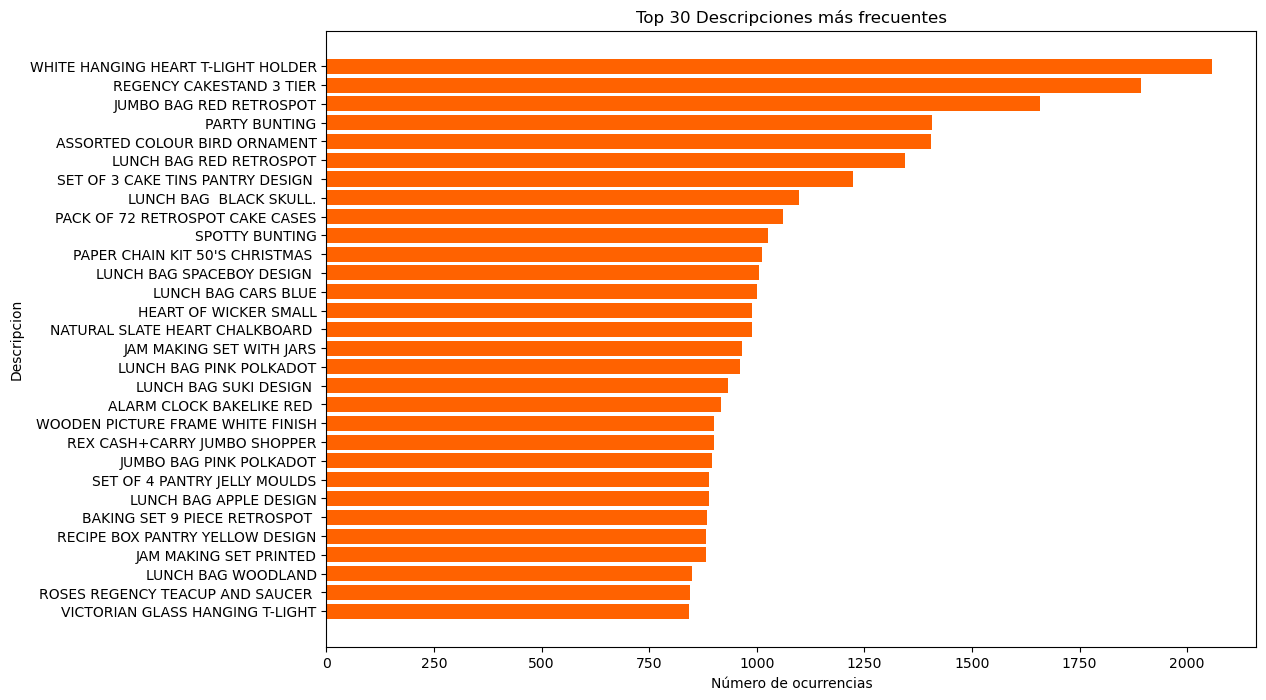

In [107]:
# Calcula la ocurrencia de cada descripción única y ordenalas
description_counts = df['Description'].value_counts()

# Obtener las 30 descripciones más frecuentes
top_30_descriptions = description_counts[:30]

# Crear un gráfico de barras horizontales
plt.figure(figsize=(12,8))
plt.barh(top_30_descriptions.index[::-1], top_30_descriptions.values[::-1], color='#ff6200')

# Añadir etiquetas y título
plt.xlabel('Número de ocurrencias')
plt.ylabel('Descripcion')
plt.title('Top 30 Descripciones más frecuentes')

# Mostar el gráfico
plt.show()

In [108]:
# Encuentra descripciones únicas que contienen caracteres en minúscula
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Imprimir las descripciones únicas que contienen caracteres en minúscula
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
Next Day Carriage
THE KING GIFT BAG 25x24x12cm
High Resolution Image


Vemos que hay un par de artículos con descripciones extrañas, veamos que son:

In [109]:
df[df['Description'] == 'Next Day Carriage'].count()

InvoiceNo             80
StockCode             80
Description           80
Quantity              80
InvoiceDate           80
UnitPrice             80
CustomerID            80
Country               80
Status                80
TotalLine             80
ProductTotalSales     80
ProductTotalCancel    80
ProductTotalNet       80
TotalInvoice          80
ClientTotalSales      80
ClientTotalCancel     80
dtype: int64

Tanto High Resolution Image como Next day Carriage son servicios, como buscamos hacer un recomendador de productos, no queremos que recomiende servicios. En el caso de next day carriage, quizas haya relaciones entre los clientes y ese servicio, en el caso de High Resolution Image solo hay 3 pedidos y en el caso de Next day Carriage hay 80 pedidos. AL ser un tamaño bastante pequeño en relación con el Dataset, vamos a eliminarlos también.

In [110]:
# Eliminar entradas con descripcion == Next day Carriage o High Resolution Image

df = df[~df['Description'].isin(['Next Day Carriage', 'High Resolution Image'])]

In [111]:
# Encuentra descripciones únicas que contienen caracteres en minúscula
lowercase_descriptions = df['Description'].unique()
lowercase_descriptions = [desc for desc in lowercase_descriptions if any(char.islower() for char in desc)]

# Imprimir las descripciones únicas que contienen caracteres en minúscula
print("The unique descriptions containing lowercase characters are:")
print("-"*60)
for desc in lowercase_descriptions:
    print(desc)

The unique descriptions containing lowercase characters are:
------------------------------------------------------------
BAG 500g SWIRLY MARBLES
POLYESTER FILLER PAD 45x45cm
POLYESTER FILLER PAD 45x30cm
POLYESTER FILLER PAD 40x40cm
FRENCH BLUE METAL DOOR SIGN No
BAG 250g SWIRLY MARBLES
BAG 125g SWIRLY MARBLES
3 TRADITIONAl BISCUIT CUTTERS  SET
NUMBER TILE COTTAGE GARDEN No
FOLK ART GREETING CARD,pack/12
ESSENTIAL BALM 3.5g TIN IN ENVELOPE
POLYESTER FILLER PAD 65CMx65CM
NUMBER TILE VINTAGE FONT No 
POLYESTER FILLER PAD 30CMx30CM
POLYESTER FILLER PAD 60x40cm
FLOWERS HANDBAG blue and orange
THE KING GIFT BAG 25x24x12cm


Bien, ahora vamos a estandarizar los textos poniendo todo en minusculas


In [112]:
# Poner las descripciones en minusculas

df['Description'] = df['Description'].str.lower()

In [113]:
df['Description'].head()

0     white hanging heart t-light holder
1                    white metal lantern
2         cream cupid hearts coat hanger
3    knitted union flag hot water bottle
4         red woolly hottie white heart.
Name: Description, dtype: object

In [114]:
df.shape[0]

399567

Quedan 399.657 registros

Vamos a guardar el dataframe en un archivo tal y como lo tenemos ahora mismo, antes de comenzar con una ingenieria de características más profunda

In [115]:
# Guardar dataset en archivo csv
df.to_csv('data_cleaned.csv', index=False)